In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
categories = ['Accessories', 'Electronics', 'Office', 'Men\'s', 'Women\'s', 'Shop by Brand']
category = categories[2]

In [15]:
df = pd.read_csv('data_modeling.csv')
df = df[df['category'] == category]
df = df.drop('category', axis=1)
df['total_transactions'] = df['total_transactions'].astype('float')

df['date'] = pd.to_datetime(df['date'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 2431 to 2796
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   366 non-null    datetime64[ns]
 1   total_hits                             366 non-null    float64       
 2   total_visits                           366 non-null    float64       
 3   total_page_views                       366 non-null    float64       
 4   total_first_visits                     366 non-null    float64       
 5   total_time_on_site                     366 non-null    float64       
 6   avg_time_on_site                       366 non-null    float64       
 7   total_transactions                     366 non-null    float64       
 8   total_revenue                          366 non-null    float64       
 9   avg_revenue                            366 non-null    float6

,date,total_hits,total_visits,total_page_views,total_first_visits,total_time_on_site,avg_time_on_site,total_transactions,total_revenue,avg_revenue,...,medium_not_set,medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,action_Check_out,action_Click_through_of_product_lists,action_Completed_purchase,action_Product_detail_views
2431,2016-08-01,18143.0,334.0,11735.0,163.0,271330.0,812.365269,18.0,1.855400e+09,1.030778e+08,...,0,0,39,10,48,9,0,186,0,148
2432,2016-08-02,15340.0,322.0,10386.0,136.0,330006.0,1024.863354,28.0,1.546480e+09,7.029455e+07,...,0,0,23,2,145,10,0,176,0,146
2433,2016-08-03,12315.0,192.0,8223.5,185.0,222286.5,2538.680263,0.0,0.000000e+00,0.000000e+00,...,0,0,14,0,152,12,0,204,0,180
2434,2016-08-04,17625.0,331.0,11758.0,134.0,351495.0,1061.918429,16.0,1.375400e+09,8.596250e+07,...,0,3,2,0,102,8,0,186,0,145
2435,2016-08-05,25145.0,344.0,18238.0,194.0,569107.0,1654.380814,92.0,1.872531e+10,2.035360e+08,...,0,0,67,0,146,8,0,189,0,155


In [16]:
# Time splitting 
n_days = 90
max_date = df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

test = df[df['date'] <= cutoff]
train = df[df['date'] > cutoff]

test = test.set_index('date')
train = train.set_index('date')

In [17]:
# Preparation
test_target = test[['total_revenue']]
test_fields = test.drop(['total_revenue', 'avg_revenue', 'total_transactions'], axis=1)


train_target = train[['total_revenue']]
train_fields = train.drop(['total_revenue', 'avg_revenue', 'total_transactions'], axis=1)

In [18]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=123)

# model = GridSearchCV(estimator=xgb_reg, 
#                              param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
#                              scoring='neg_mean_absolute_error',
#                              refit=True,
#                              cv=5)

# model.fit(train_fields, train_target)

In [19]:
# print("Best score: ", model.best_score_)
# print("Best params: ", model.best_params_)
# print("Best estimator: \n", model.best_estimator_)

In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(train_fields, train_target.values.reshape(-1, ))

RandomForestRegressor(random_state=42)

<Axes: >

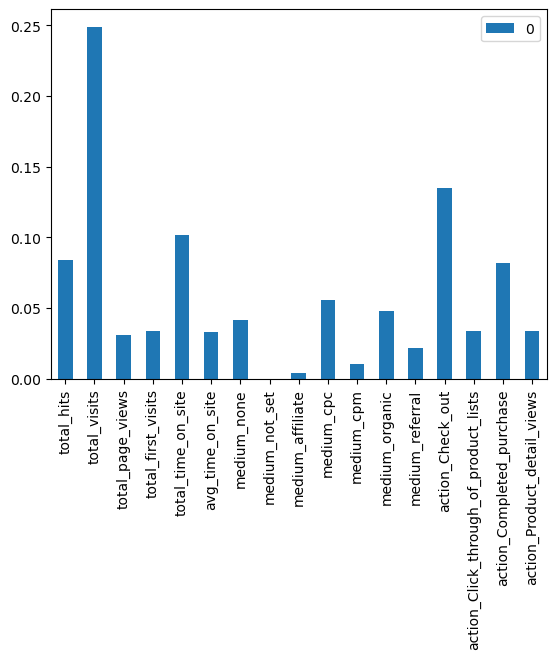

In [21]:
# imp_feat_reg = model\
#                 .best_estimator_\
#                 .get_booster()\
#                 .get_score(importance_type='gain')

imp_feat_reg = model.feature_importances_

# pd.DataFrame.from_dict(imp_feat_reg, orient='index').plot(kind='bar')
# plt.show()
pd.DataFrame(imp_feat_reg.reshape(1, -1), columns=train_fields.columns).T.plot(kind='bar')

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

predictions_reg = model.predict(test_fields)
predictions_reg = pd.DataFrame(predictions_reg, index=test.index, columns=['pred_total_revenue'])

# Calculate performance metrics
mse = mean_squared_error(test_target, predictions_reg)
r2 = r2_score(test_target, predictions_reg)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

df_pred = pd.merge(test_target, predictions_reg, left_index=True, right_index=True)
df_pred

Mean Squared Error: 2.7887611632966864e+20
R^2 Score: 0.04848681075202399


,total_revenue,pred_total_revenue
date,,
2016-08-01,1.855400e+09,1.811708e+10
2016-08-02,1.546480e+09,1.858613e+10
2016-08-03,0.000000e+00,1.857706e+10
2016-08-04,1.375400e+09,2.015802e+10
2016-08-05,1.872531e+10,1.777586e+10
...,...,...
2017-04-29,1.217080e+09,1.487250e+09
2017-04-30,3.181458e+09,6.648413e+09
2017-05-01,1.273822e+10,2.569656e+10


In [23]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = px.line(df_pred.resample('M').mean(), labels={'value': 'Total Revenue'})
fig.show()

In [24]:
df_result = df_pred.copy().reset_index()
df_result['category'] = [category] * df_pred.shape[0]

df_result.to_csv(f'prediction-revenue-{category}.csv', index=False)